## Cancer Stem Cell Model-- Tumor simulation
Agent model based on 

### CSC neutral model

In [316]:
import pandas as pd
import numpy as np
import random
import copy
import baltic as bt
#create classes
class Cell:
    def __init__(self):
        self.parent = None #cell it was derived from
        self.children = [] #set of daughter cells
        self.locx = None #x location in lattice
        self.locy = None #y location in lattice
        self.birthdate = None
        self.deathdate = None
        self.pmax = 10 #proliferation potential
        self.cellnum = None #unique cell number to identify
        self.alpha = 0.01 #probability of sponaneous death
        self.mutation_rate = 0.1 #probability of mutation per cell division
        self.motility = None #probability of migration per day
        self.proliferation_rate = None #average cell divisions per day
        self.clone = None
        self.mutations = []
        self.ps = 0
        self.curnode = None

class StemCell(Cell): #define stem cell class
    def __init__(self):
        Cell.__init__(self)
        self.pmax = float('inf') #infinite proliferation potential
        self.alpha = 0 #immortal
        self.ps = 0 #probability of symmetric division

class Clone(): #define clone class
    def __init__(self):
        self.parent = None
        self.children = []
        self.birthdate = None
        self.deathdate = None
        self.color = None
        self.clonenum = None
        self.mutations = []
        self.alive_cells = []
        self.node = None
class Mutation(): #definate mutation class
    def __init__(self):
        self.cells = []
        self.alive_cells = []
        self.mutnum = 'None'
        
#create lattice array
N = 10000 # starting demensions of lattice
lattice = np.empty( (N,N), dtype=object)

#parameters
proliferation_rate_CC = 2
proliferation_rate_CSC = 1
pmax_CC = 10
migration_potential = 15
alpha_CC = 0.05
cur_cellnum = 1
cur_mutnum = 0
cur_clonenum = 1
cur_index = 1
mutation_rate = 0.1

i = int(N/2) #to place founder cell in center of lattic
Fcell = StemCell() #initiate founder cell
Fcell.locx = i #x location in lattice
Fcell.locy = i #y location in lattice
Fcell.birthdate = 0
Fcell.cellnum = 0  #unique cell number to identify
Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
Fcell.motility = migration_potential #probability of migration per day
Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per da
Fcell.ps = 0.05

tree = bt.tree()
root = bt.node()
root.length=0 ## branch length,
root.height=0 ## height, set by traversing the tree, which adds up branch lengths along the way
root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
root.index='root' ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
root.x=0## X and Y coordinates of this node, once drawTree() is called
tree.Objects.append(root)
tree.nodes.append(root)
tree.root = root

Fcell.curnode = root



#initial founder clone object
Fclone = Clone()
Fclone.clone_num = 0
Fclone.birthdate = 0
Fcell.clone = Fclone
Fclone.alive_cells.append(Fcell)
#Fclone.node = root

#initiate desired tracking system
simpsons_diversity = [] #list to keep track of diversity at each time step
clones = [] #list to contain each clone in population
clones.append(Fclone) #add founding clone to list
alive_cells = [] #list to keep track of cells currently alive in population
alive_cells.append(Fcell)
mutations = []


#time parameters
dt = 1/float(24) # time is equilavent to 1/24 of a day or 1 hour
time = 0 #initialize time to 0
stop_time = 20 #stop simulation after this many days


def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
    free_cells = []
    change = [1,-1]
    for c in change:
        checki = lattice[i+c,j]
        if checki == None:
            free_cells.append([i+c,j])
        checkj = lattice[i, j+c]
        if checkj == None:
            free_cells.append([i,j+c])
        for h in change:
            checkd = lattice[i+h,j+c]
            if checkd == None:
                free_cells.append([i+h,j+c])
    return free_cells

while time < stop_time:
    time += dt
    cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
    for cell in cell_stack:
        alive = True
        r = random.uniform(0, 1)
        pd = cell.proliferation_rate * dt #probability of proliferation in time dt
        free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
        if r < pd: # Does cell attempt to divide? 
            r = random.uniform(0,1)
            pdie = cell.alpha * pd #probability of spontaneously dying
            if r < pdie:
                alive = False
            elif len(free_cells) > 0: #is there any space to divide?
                if cell.pmax > 0: #is cell proliferation capacity exhausted?
                    r = random.uniform(0,1)
                    if r <= cell.ps: #does cell divide asymmetrically?
                        new_cell = Cell()
                        new_cell.mutation_rate = cell.mutation_rate * 2 #probability of mutation per cell division
                        new_cell.motility = cell.motility#probability of migration per day
                        new_cell.proliferation_rate = cell.proliferation_rate #average cell divisions per day
                        new_cell.clone = cell.clone
                        new_cell.mutations = cell.mutations
                        new_cell.alpha = cell.alpha + 0.01
                    else:
                        new_cell = copy.deepcopy(cell)
                        
                    new_cell.parent = cell
                    newloc = random.choice(free_cells)
                    new_cell.locx = newloc[0] #x location in lattice
                    new_cell.locy = newloc[1] #y location in lattice
                    new_cell.birthdate = time
                    new_cell.cellnum = cur_cellnum #unique cell number to identify
                    cur_cellnum += 1
                    new_cell.children = []
                    new_cell.mutations = cell.mutations
                    new_cell.curnode = cell.curnode
                    new_cell.clone = cell.clone
                    

                    r = random.uniform(0,1)
                    if r < cell.mutation_rate: #does cell gain a mutation?
                        new_mut = Mutation()
                        new_mut.mutnum = cur_mutnum
                        new_cell.mutations.append(new_mut)
                        new_clone = Clone() #new mutation defines new clone group
                        new_clone.parent = cell.clone
                        new_clone.birthdate = time
                        new_clone.clonenum = cur_clonenum
                        cur_clonenum += 1
                        new_clone.parent.children.append(new_clone) 
                        new_clone.children.append(new_cell)
                        new_clone.alive_cells.append(new_cell)
                        new_cell.clone= new_clone
                        clones.append(new_clone)
                        mutations.append(new_mut)
                        new_node = bt.node()
                        new_node.length= time - cell.curnode.x ## branch length,
                        new_node.height = time
                        new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                        new_node.parent=cell.curnode ## reference to parent node of the node
                        new_node.index=cur_index ## index of the character designating this object
                        cur_index += 1
                        new_node.locx = cell.locx
                        new_node.locy = cell.locy
                        new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
                        new_cell.curnode = new_node
                        cell.curnode = new_node
                        #new_clone.node = new_node
                        new_node.parent.children.append(new_node)
                        tree.Objects.append(new_node)
                        tree.nodes.append(new_node)


                    else:
                        cell.clone.alive_cells.append(new_cell)
                        
                    for mut in new_cell.mutations:
                        mut.alive_cells.append(new_cell)
                        mut.cells.append(new_cell)
                        
                    cell.children.append(new_cell)
                    alive_cells.append(new_cell)
                    lattice[new_cell.locx,new_cell.locy] = new_cell
                    cell.pmax -= 1        
                else:
                    alive = False
            elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
                if len(free_cells) > 0:
                    newloc = random.choose(free_cells)
                    lattice[cell.locx,cell.locy] = 'None'
                    cell.locx = newloc[0]
                    cell.locy = newloc[1]
                    lattice[cell.locx,cell.locy] = cell
        if alive == False:
            alive_cells.remove(cell)
            cell.deathdate = time
            cell.clone.alive_cells.remove(cell)
            if len(cell.clone.alive_cells) < 1:
                cell.clone.deathdate = time
            if len(cell.mutations)>0:
                for mut in cell.mutations:
                    mut.alive_cells.remove(cell)
                if len(mut.alive_cells) < 1:
                    mutations.remove(mut)
            new_leaf = bt.leaf()
            new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
            cur_index += 1
            new_leaf.numName = new_leaf.index
            new_leaf.length=time - cell.curnode.x ## branch length
            new_leaf.absoluteTime=time ## position of tip in absolute time
            new_leaf.parent=cell.curnode ## parent
            new_leaf.parent.children.append(new_leaf)
            new_leaf.x=time## position of tip on x axis if the tip were to be plotted
            new_leaf.locx = cell.locx
            new_leaf.locy = cell.locy
            new_leaf.clone = cell.clone
            tree.Objects.append(new_leaf)
            tree.leaves.append(new_leaf)

ValueError: list.remove(x): x not in list

In [317]:
usedparents = []
for cell in alive_cells:
    if not (cell.curnode in usedparents):
        new_leaf = bt.leaf()
        new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
        cur_index += 1
        new_leaf.length=stop_time - cell.curnode.x ## branch length
        new_leaf.height = stop_time
        new_leaf.absoluteTime=stop_time ## position of tip in absolute time
        new_leaf.parent=cell.curnode ## parent
        new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
        new_leaf.parent.children.append(new_leaf)
        new_leaf.numName = new_leaf.index
        new_leaf.clone = cell.clone
        tree.Objects.append(new_leaf)
        tree.leaves.append(new_leaf)
        curnode = new_leaf.parent
        while curnode != None:
            curnode.leaves.append(new_leaf)
            curnode = curnode.parent
        usedparents.append(new_leaf.parent)
    

tree.treeHeight = stop_time
for n in tree.nodes:
    n.numChildren = len(n.children)
    


In [318]:
tree.traverse_tree
tree.drawTree()

In [319]:
from operator import attrgetter
diff = 1.0/len(clones)
sortedclones = sorted(clones, key=attrgetter('birthdate'))




In [320]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
## Magic words for jupyter notebooks

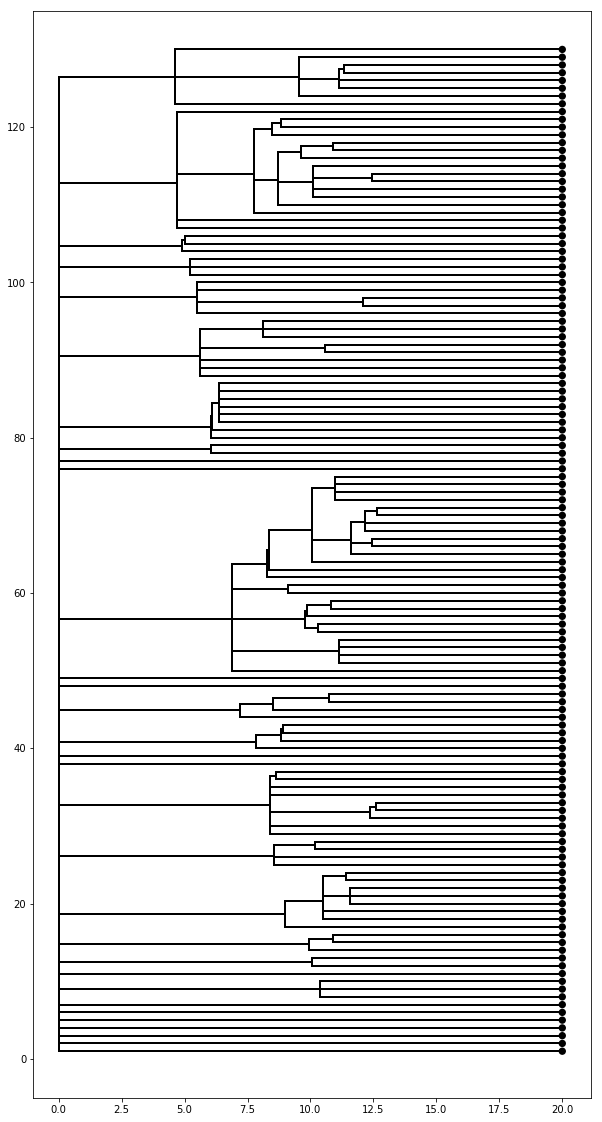

In [321]:
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    c = 'k'
    #if (isinstance(k, bt.leaf) or k.branchType=='leaf') and len(k.name.split('|')) > 1:
    #if isinstance(k, bt.leaf) and len(k.name.split('|')) > 1:
        #c = colors[k.name.split('|')[-3]]
    #else:
        #c='dimgray' ## colour can be fixed
    #if k.traits['clone'] != 'nan':
        #c = colors2[k.traits['clone']] if k.traits.has_key('clone') else cmap(1.0)[0]
    #else: c = 'silver'
#     c=cmap(k.height/ll.treeHeight) ## or be a function of something else
#     c=[cmap(k.traits['host.prob']) if k.traits.has_key('host.prob') else cmap(1.0)][0]
#     c=['indianred' if k.traits['PB1']=='V' else 'steelblue'][0] ## can be discrete too
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,tree.ySpan+5)
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultationtree.png')
plt.show()

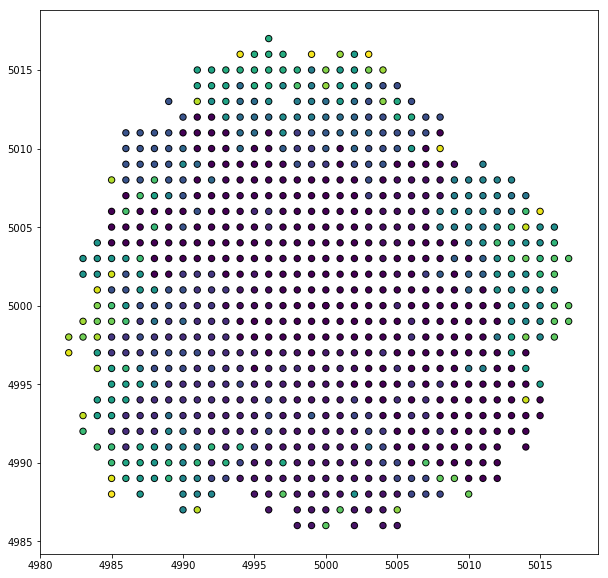

In [322]:
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w')
cmap=mpl.cm.viridis 
for a in alive_cells:
    c = 'k'
    cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
    color = np.linspace(0,1,len(clones))[cindx[0]]
    c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultationtree.png')
plt.show()

In [280]:
np.linspace(0,1,len(clones))

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
        0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ])

True